In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

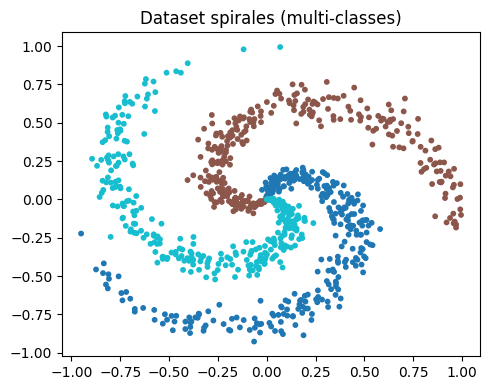

In [5]:
def make_spirals(n_per_class=300, K=3, noise=0.2, random_state=42):
    rng = np.random.RandomState(random_state)
    N = n_per_class * K
    X = np.zeros((N, 2), dtype=np.float32)
    y = np.zeros(N, dtype=np.int64)

    for k in range(K):
        ix = range(k*n_per_class, (k+1)*n_per_class)
        r = np.linspace(0.0, 1, n_per_class)          # rayon
        t = np.linspace(k*4, (k+1)*4, n_per_class)    # angle de base
        t += rng.normal(scale=noise, size=n_per_class) # bruit
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = k
    return X, y

# Dataset
K = 3
X, y = make_spirals(n_per_class=300, K=K, noise=0.25, random_state=0)

plt.figure(figsize=(5,4))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.tab10, s=10)
plt.title("Dataset spirales (multi-classes)")
plt.tight_layout()
plt.show()

# Tensors
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.long)  

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_t, y_t, test_size=0.2, random_state=42, stratify=y_t
)



In [6]:
model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, K)   # logits multi-classes
)

criterion = nn.CrossEntropyLoss()          # pour multi-classes
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


In [7]:
def accuracy(logits, y_true):
    preds = logits.argmax(dim=1)
    return (preds == y_true).float().mean().item() * 100

epochs = 200
for epoch in range(1, epochs+1):
    # Train
    model.train()
    logits = model(X_train)
    loss = criterion(logits, y_train)
    acc  = accuracy(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Test
    model.eval()
    with torch.no_grad():
        test_logits = model(X_test)
        test_loss = criterion(test_logits, y_test)
        test_acc  = accuracy(test_logits, y_test)

    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | "
              f"Train Loss {loss.item():.4f} | Train Acc {acc:.2f}% | "
              f"Test Loss {test_loss.item():.4f} | Test Acc {test_acc:.2f}%")

Epoch 020 | Train Loss 0.4616 | Train Acc 75.97% | Test Loss 0.4925 | Test Acc 75.00%
Epoch 040 | Train Loss 0.1431 | Train Acc 97.08% | Test Loss 0.1640 | Test Acc 94.44%
Epoch 060 | Train Loss 0.0543 | Train Acc 99.31% | Test Loss 0.0709 | Test Acc 97.78%
Epoch 080 | Train Loss 0.0331 | Train Acc 99.86% | Test Loss 0.0467 | Test Acc 98.89%
Epoch 100 | Train Loss 0.0253 | Train Acc 99.86% | Test Loss 0.0372 | Test Acc 98.89%
Epoch 120 | Train Loss 0.0211 | Train Acc 99.86% | Test Loss 0.0327 | Test Acc 98.89%
Epoch 140 | Train Loss 0.0182 | Train Acc 99.86% | Test Loss 0.0297 | Test Acc 98.89%
Epoch 160 | Train Loss 0.0160 | Train Acc 99.86% | Test Loss 0.0275 | Test Acc 98.89%
Epoch 180 | Train Loss 0.0143 | Train Acc 99.86% | Test Loss 0.0258 | Test Acc 99.44%
Epoch 200 | Train Loss 0.0129 | Train Acc 99.86% | Test Loss 0.0244 | Test Acc 99.44%


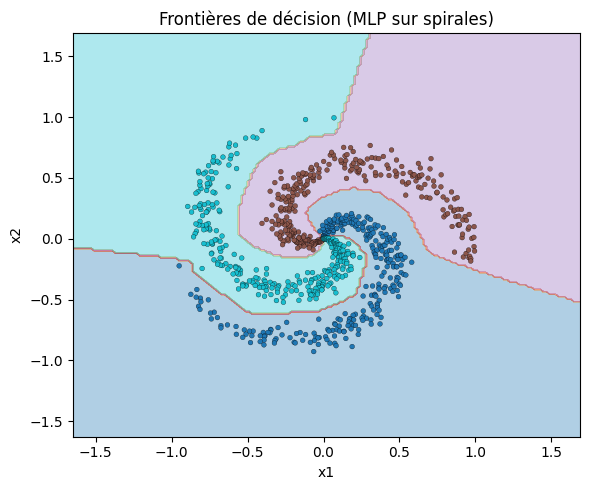

In [ ]:
X_np = X_t.numpy()
y_np = y_t.numpy()
x_min, x_max = X_np[:,0].min() - 0.7, X_np[:,0].max() + 0.7
y_min, y_max = X_np[:,1].min() - 0.7, X_np[:,1].max() + 0.7

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
grid_t = torch.from_numpy(grid)

model.eval()
with torch.no_grad():
    logits_grid = model(grid_t)           # (N, K)
    Z = logits_grid.argmax(dim=1).numpy() # classes prédites

Z = Z.reshape(xx.shape)

plt.figure(figsize=(6,5))
# Fond des régions
plt.contourf(xx, yy, Z, alpha=0.35, cmap=plt.cm.tab10)
# Points
plt.scatter(X_np[:,0], X_np[:,1], c=y_np, cmap=plt.cm.tab10, s=12, edgecolors='k', linewidths=0.2)
plt.title("Frontières de décision (MLP sur spirales)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout()
plt.show()